In [103]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Generate fake time series data
np.random.seed(0)

In [152]:

# Create a sine wave time series with some noise
time_steps = 1000
t = np.linspace(0, 20, time_steps)
y = np.sin(3*t) + np.random.normal(0, 0.1, time_steps) + t/10 + np.cos(5*t)

In [144]:
dataset_name = "co2_emissions_coal"
dataset_folder = "datasets"
value_column = "Emissions [MMT]"

df = pd.read_csv(Path(dataset_folder) / dataset_name / f"{dataset_name}.csv", index_col="YYYYMM") 
ts = df[value_column]
ts.index = pd.to_datetime(ts.index)

t = np.arange(len(ts))
y = ts.values


In [153]:


# Convert data to PyTorch tensors
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create sliding window dataset (e.g., predict next value based on the previous 10 time steps)
def create_dataset(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return torch.stack(X), torch.stack(y)

window_size = 30
X, y = create_dataset(y_tensor, window_size)
X = X[:,:,0]

# Split into training and validation sets
train_size = int(0.5 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [154]:
print(X.shape)
print(y.shape)

torch.Size([970, 30])
torch.Size([970, 1])


In [155]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, num_heads, output_size):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_dim)
        self.transformer = nn.Transformer(d_model=hidden_dim, 
                                          nhead=num_heads, 
                                          num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers, 
                                          dim_feedforward=hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        # Embed the input (batch_size, input_size) -> (batch_size, hidden_dim)
        x = self.embedding(x)  
        # Add a sequence length dimension (seq_len, batch_size, hidden_dim)
        x = x.unsqueeze(0)  # shape becomes (1, batch_size, hidden_dim)
        # Pass through transformer
        x = self.transformer(x, x)  # Transformer expects (seq_len, batch_size, hidden_dim)
        # Remove the sequence length dimension
        x = x.squeeze(0)  # shape becomes (batch_size, hidden_dim)
        # Pass through the output layer
        x = self.fc_out(x)  # shape becomes (batch_size, output_size)
        return x

# Example usage
input_size = window_size
hidden_dim = 64
num_layers = 2
num_heads = 4
output_size = 1  # Predict the next time step

model = TimeSeriesTransformer(input_size, hidden_dim, num_layers, num_heads, output_size)

In [156]:
X_train.shape

torch.Size([485, 30])

In [157]:
torch.manual_seed(1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 2000
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

Epoch 0/2000, Loss: 1.821938157081604
Epoch 100/2000, Loss: 0.046283233910799026
Epoch 200/2000, Loss: 0.02996212989091873
Epoch 300/2000, Loss: 0.020075393840670586
Epoch 400/2000, Loss: 0.027311859652400017
Epoch 500/2000, Loss: 0.01721520908176899
Epoch 600/2000, Loss: 0.01584199070930481
Epoch 700/2000, Loss: 0.017798207700252533
Epoch 800/2000, Loss: 0.013678614050149918
Epoch 900/2000, Loss: 0.01347332913428545
Epoch 1000/2000, Loss: 0.01566925272345543
Epoch 1100/2000, Loss: 0.01895434409379959
Epoch 1200/2000, Loss: 0.01287535484880209
Epoch 1300/2000, Loss: 0.01290912926197052
Epoch 1400/2000, Loss: 0.01127592846751213
Epoch 1500/2000, Loss: 0.012469365261495113
Epoch 1600/2000, Loss: 0.011626717634499073
Epoch 1700/2000, Loss: 0.011367525905370712
Epoch 1800/2000, Loss: 0.010120851919054985
Epoch 1900/2000, Loss: 0.010862716473639011


In [158]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Predict on training set
    y_train_pred = model(X_train).detach().numpy()
    # Predict on validation set
    y_val_pred = model(X_val).detach().numpy()

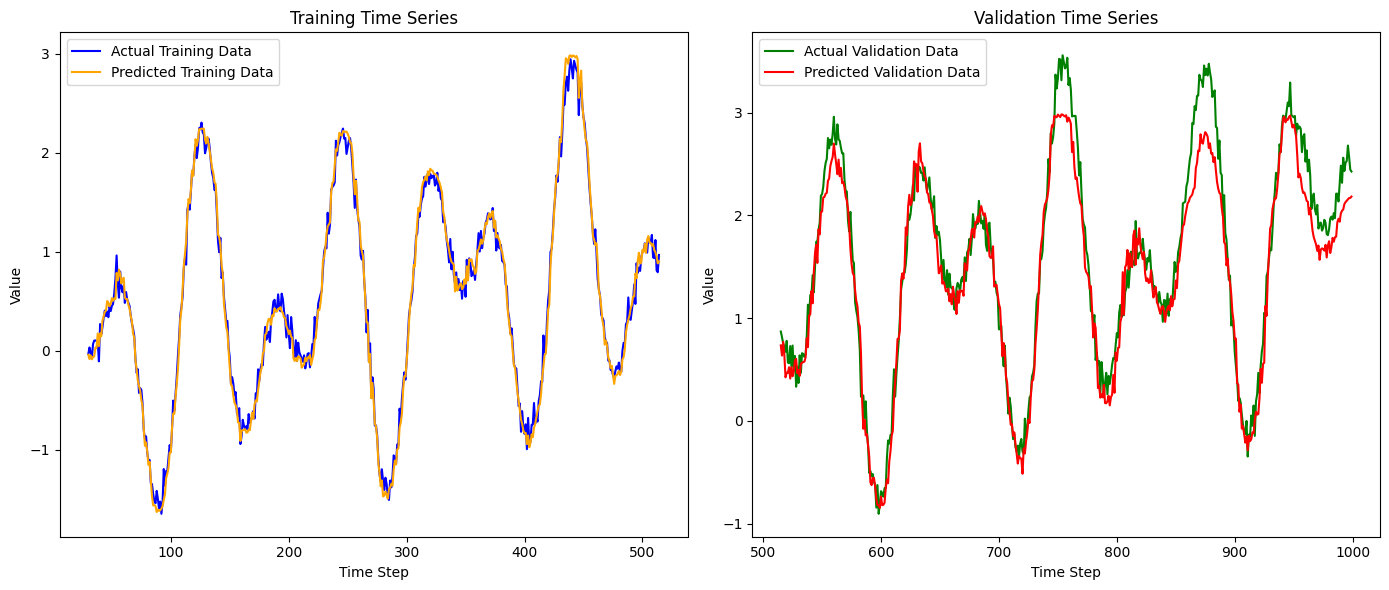

In [159]:
# Convert predictions to the correct shape for plotting
y_train_pred = y_train_pred.flatten()
y_val_pred = y_val_pred.flatten()
y_train = y_train.flatten()
y_val = y_val.flatten()

# Plot the actual and predicted time series for training and validation
plt.figure(figsize=(14, 6))

# Plot training data and predictions
plt.subplot(1, 2, 1)
plt.plot(np.arange(window_size, window_size + len(y_train)), y_train, label='Actual Training Data', color='blue')
plt.plot(np.arange(window_size, window_size + len(y_train_pred)), y_train_pred, label='Predicted Training Data', color='orange')
plt.title('Training Time Series')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Plot validation data and predictions
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(y_train) + window_size, len(y_train) + window_size + len(y_val)), y_val, label='Actual Validation Data', color='green')
plt.plot(np.arange(len(y_train) + window_size, len(y_train) + window_size + len(y_val_pred)), y_val_pred, label='Predicted Validation Data', color='red')
plt.title('Validation Time Series')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()